In [1]:
%load_ext autoreload
import sys
sys.path.append("../..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('../matplotlibrc')
import matplotlib.pyplot as plt
import pickle

import numpy as np
from scipy.interpolate import interp1d

import darkhistory.physics as phys
import darkhistory.low_energy.atomic as atomic
import darkhistory.low_energy.bound_free as bf

In [4]:
from config import load_data
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.spectools as spectools
binning = load_data('binning')

# Reproducing case-B Recombination Coefficients

In [5]:
rs_vec = 10**np.arange(1,4,.5)
Tr_vec = phys.TCMB(rs_vec)
Tm_vec = phys.Tm_std(rs_vec)
length = len(rs_vec)

In [6]:
def alpha_recomb_full_Kot(T_over_rydberg):
    return (
        8.414*(np.log(1 + 1./T_over_rydberg) + 3.499) * (phys.alpha**4 * phys.c * phys.bohr_rad**2) 
        / (T_over_rydberg**0.5 + 0.6517*T_over_rydberg +   0.2138*T_over_rydberg**(3/2))
    )
def alpha_recomb_1_Kot(T_over_rydberg):
    return (
        17.41 * (phys.alpha**4 * phys.c * phys.bohr_rad**2) 
        / (T_over_rydberg**0.5 + 0.3593*T_over_rydberg**(7/6) + 0.1471*T_over_rydberg**(3/2))
    )

In [7]:
# Tm^1/2 * alpha_B from Hummer 1994 MNRAS
Tm_alphaB_Hummer = np.array([
    9.283e-11, 8.823e-11, 8.361e-11,
    7.898e-11, 7.435e-11, 6.973e-11,
    6.512e-11, 6.054e-11, 5.599e-11,
    5.147e-11, 4.700e-11, 4.258e-11,
    3.823e-11, 3.397e-11, 2.983e-11,
    2.584e-11, 2.204e-11, 1.847e-11,
    1.520e-11, 1.226e-11, 9.696e-12,
    7.514e-12, 5.710e-12, 4.257e-12,
    3.117e-12, 2.244e-12, 1.590e-12,
    1.110e-12, 7.642e-13, 5.199e-13,
3.498e-13])

#Convert to eV
Tm_Hummer = 10**np.arange(1,7.2,.2)*phys.kB

alphaB_Hummer = interp1d(Tm_Hummer, Tm_alphaB_Hummer/np.sqrt(Tm_Hummer/phys.kB))

In [42]:
nmax=10
k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
alpha = atomic.populate_alpha(1, 1e-20, nmax, k2_tab, g)

In [29]:
%autoreload
# alpha_B requires many excited states to converge (see Hummer Fig. 1)
nmax = 300
Delta_f = lambda a : 0

alpha_tot=np.zeros(length)
alpha_tot_Hongwan=np.zeros(length)
for i, rs in enumerate(rs_vec):
    Tm = phys.Tm_std(rs)

#     k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
#     alpha = atomic.populate_alpha(Tm, phys.TCMB(rs)/1e20, nmax, k2_tab, g)
#     alpha_tot[i] = np.sum(alpha)
    alpha_tot_Hongwan[i] = bf.alpha_B(Tm,stimulated_emission=False, n=nmax)
    print(rs, alpha_tot_Hongwan[i])
    
#!!! Need to double-check the stimulated emission coefficient

10.0 6.676905222636025e-11
31.622776601683793 1.8319448465094328e-11
100.0 5.000663272886823e-12
316.22776601683796 1.7110407407695503e-12
1000.0 7.172861897808398e-13
3162.2776601683795 2.919585396875446e-13


In [33]:
if nmax==10:
    alpha_tot10 = alpha_tot.copy()
elif nmax==20:
    alpha_tot20 = alpha_tot.copy()
elif nmax==50:
    alpha_tot50 = alpha_tot.copy()
elif nmax==100:
    alpha_tot100 = alpha_tot.copy()
elif nmax==300:
    alpha_tot300 = alpha_tot.copy()

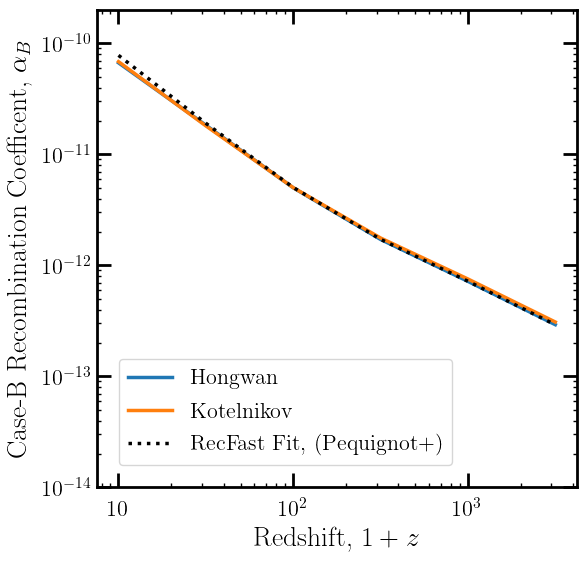

In [149]:
rs_vec = 10**np.arange(1,4,.5)
Tm_vec = phys.Tm_std(rs_vec)
plt.figure()
plt.loglog()
plt.ylim([1e-14,2e-10])

# plt.plot(rs_vec[Tm_vec>8e-4], alphaB_Hummer(Tm_vec[Tm_vec>8e-4]), label='Hummer 1994')

# plt.plot(rs_vec, alpha_tot10, label=r'DH, $n_{\mathrm{max}}=10$')
# plt.plot(rs_vec, alpha_tot20, label=r'DH, $n_{\mathrm{max}}=20$')
# plt.plot(rs_vec, alpha_tot50, label=r'DH, $n_{\mathrm{max}}=50$')
# plt.plot(rs_vec, alpha_tot100, label=r'DH, $n_{\mathrm{max}}=100$')
# plt.plot(rs_vec, alpha_tot300, label=r'DH, $n_{\mathrm{max}}=300$')

plt.plot(rs_vec, alpha_tot_Hongwan, label=r'Hongwan')

tmp = alpha_recomb_full_Kot(Tm_vec/phys.rydberg)-alpha_recomb_1_Kot(Tm_vec/phys.rydberg)
plt.plot(rs_vec, tmp, label=r'Kotelnikov')
plt.plot(rs_vec, phys.alpha_recomb(Tm_vec, 'HI')/1.125, label='RecFast Fit, (Pequignot+)', color='k', linestyle=':')
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Case-B Recombination Coefficent, $\alpha_B$', fontsize=20)
plt.legend()

$\beta_B$ is obtained by detailed balance. 
First, use $x_i \beta_i \sim \frac1{g_i}e^{-E_i/T_m}\alpha_i$.
Next, assume $x_i = x_{2s}\frac{g_i}{g_{2s}} e^{-(E_2-E_i)/T_m}$. 
Finally, write the ionization term in the $x_e$ evolution equation as 
$$
\sum_i \beta_i x_i = x_{2s}\frac{g_i}{g_{2s}} e^{-(E_2-E_i)/T_m} \sim x_{2s}e^{-E_2/T_m} \alpha_B \sim \beta_B x_{2s}
$$
So a cross-cheeck of $\alpha_B$ is a cross-check of $\beta_B$.

# Deviations from TLA Assumptions

The TLA assumes that the excited states obey the detailed balance condition
$$
\begin{alignat}{1}
	\frac{x_i}{x_{2s}} = g_i e^{-(E_i-E_\alpha)/T} \, ,
\end{alignat}
$$
that the $n=2$ state obeys
$$
\begin{alignat}{1}
	x_2 = & \frac{x_{1s}e^{-E_\alpha/T} (3 R_{\text{Ly}\alpha} + \Lambda_{2s}) + x_e^2 n_H \alpha_\text{B}}{
	\frac34 R_{\text{Ly}\alpha} + \frac14 \Lambda_{2s} + \beta_\text{B}}   \, ,
\end{alignat}
$$
and that the substates satisfy 
$$
\begin{alignat}{1}
	x_{2p} = & \frac34 x_2 \\
    x_{2s} = & \frac14 x_2 \, .
\end{alignat}
$$

We also assume that the excited state abundances are so exponentially suppressed that $$x_{1s} = 1-x_e \, .$$
Let us now see if we can reproduce this behavior.

In [31]:
%autoreload
rs_vec = 10**np.arange(1,4.55,.05)
Tr_vec = phys.TCMB(rs_vec)
Tm_vec = phys.Tm_std(rs_vec)

length = len(rs_vec)

xe_vec = phys.xHII_std(rs_vec)
x1s_vec = phys.xHI_std(rs_vec)
nH_vec  = phys.nH * rs_vec**3

#2p-1s rate without optical depth
f_Lya = np.exp(-phys.lya_eng/Tr_vec)/(1-np.exp(-phys.lya_eng/Tr_vec))
R_Lya_vec = 2**9/3**8 * phys.alpha**3 * phys.rydberg/phys.hbar * (1+f_Lya)

#Sobolev optical depth
tau_vec = atomic.tau_np_1s(2,rs_vec)
R_Lya_vec *= (1-np.exp(-tau_vec))/tau_vec

# lam_a = 2*np.pi * phys.hbar * phys.c/phys.lya_eng
# R_Lya_vec = 8*np.pi*phys.hubble(rs_vec)/(3*x1s_vec*nH_vec*lam_a**3)

#2s-1s rate
Lam2s = phys.width_2s1s_H

#Total deexcitation rate
sum_rates = (3*R_Lya_vec + Lam2s)/4

#Denominator of Peebles C factor
denom = sum_rates + phys.beta_ion(Tr_vec,'HI')

#Two numerator terms for x2 steady state solution
term1 = xe_vec**2 * nH_vec * phys.alpha_recomb(Tm_vec, 'HI')
term2 = 4 * x1s_vec * np.exp(-phys.lya_eng/Tr_vec) * sum_rates

x2_vec = (term1+term2)/denom

In [32]:
def E(n):
    return phys.rydberg/n**2

def g_nl(l):
    return 2*l+1

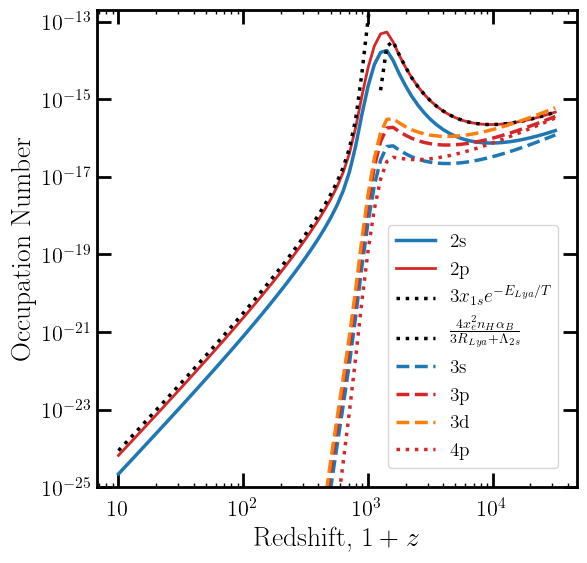

In [33]:
plt.figure()
plt.loglog()
plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

plt.plot(rs_vec, x2s_vec, label='2s', color='C0')
plt.plot(rs_vec, 3*x2s_vec, label='2p', color='C3', linewidth=2.0)
plt.plot(rs_vec[rs_vec>1.2e3], (3*x1s_vec*np.exp(-phys.lya_eng/Tr_vec))[rs_vec>1.2e3], 
         label=r'$3 x_{1s} e^{-E_{Lya} / T}$', color='k', linestyle=':')
plt.plot(rs_vec[rs_vec<1.2e3], (term1/sum_rates)[rs_vec<1.2e3], 
         label=r'$\frac{4 x_e^2 n_H \alpha_B}{3 R_{Lya} + \Lambda_{2s}}$', color='k', linestyle=':')

plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C0', linestyle='--')
plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C3', linestyle='--')
plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C1', linestyle='--')
plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(fontsize=14)

Now we would like to see if $Mx = b$ produces a solution near the above lines.

### Checking Detailed Balance

In [ ]:
#beta_nl
prefac = 1 / g_nl / lam_T**3 * np.exp(-rydberg/n**2 /T_r)

    # Define the integral (as a function of kappa2 and f_gamma)
    def integ(kappa2, f_gamma):

        # The photon energy to produce an electron with energy kappa^2. 
        E_gamma = (1. / n**2 + kappa2) * phys.rydberg

        f_gam_fac = np.exp(-E_gamma/T_r) / (1. - np.exp(-E_gamma/T_r))

        return (n * kappa2 + 1/n)**2  * f_gam_fac * (
            (l+1)*Theta(l, l+1, n, kappa=None)
            + l*Theta(l, l-1, n, kappa=None)
        )

In [ ]:
y=rydb / T_m

    return  f_gam_fac * (n * kappa2 + 1/n)**2 * (
        (l+1) * Theta(l, l+1, n, kappa=None)
        +l * Theta(l, l-1, n, kappa=None) * (l > 0)
    )

In [170]:
%autoreload

#Detailed Balance between recombination and ionization
rs = 3e3
Tr = phys.TCMB(rs)
Tm = Tr#phys.Tm_std(rs)
xe = phys.xHII_std(rs)
nH = phys.nH * rs**3
x1s = phys.xHI_std(rs)

nmax=9
new_switch=True
R = atomic.populate_radial(nmax)
BB = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
alpha = atomic.populate_alpha(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f, new_switch=new_switch)
beta = atomic.populate_beta(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f, new_switch=new_switch)

hplanck=2*np.pi*phys.hbar
lam_T = hplanck*phys.c/(2*np.pi * phys.mu_ep * Tr)**(1/2)

for n in np.arange(1,nmax+1):
    bfac = np.exp(-E(n)/Tr)
    for l in np.arange(0,n):
        print(n,l,':', beta[n][l]/(phys.rydberg/(1/2*phys.mu_ep*phys.alpha**2))**(3/2)/(
            alpha[n][l]*bfac/g_nl(l)/lam_T**3))#xe**2*nH * 

1 0 : 1.0000000000000016
2 0 : 1.0000000000000009
2 1 : 1.000000000000001
3 0 : 1.0000000000000004
3 1 : 1.0000000000000002
3 2 : 1.0000000000000004
4 0 : 1.0
4 1 : 1.0000000000000002
4 2 : 1.0000000000000004
4 3 : 1.0000000000000002
5 0 : 1.0000000000000004
5 1 : 1.0000000000000007
5 2 : 1.0000000000000007
5 3 : 1.0000000000000007
5 4 : 1.0000000000000002
6 0 : 0.9999999999999998
6 1 : 1.0
6 2 : 1.0000000000000002
6 3 : 1.0
6 4 : 1.0000000000000002
6 5 : 1.0000000000000004
7 0 : 1.0
7 1 : 1.0
7 2 : 1.0000000000000002
7 3 : 1.0
7 4 : 1.0
7 5 : 1.0
7 6 : 1.0
8 0 : 1.0
8 1 : 0.9999999999999999
8 2 : 1.0
8 3 : 0.9999999999999999
8 4 : 0.9999999999999997
8 5 : 0.9999999999999997
8 6 : 0.9999999999999999
8 7 : 0.9999999999999999
9 0 : 0.9999999999999998
9 1 : 0.9999999999999998
9 2 : 1.0
9 3 : 1.0
9 4 : 0.9999999999999998
9 5 : 1.0000000000000002
9 6 : 0.9999999999999997
9 7 : 1.0000000000000002
9 8 : 1.0000000000000002


In [67]:
%autoreload
#Saha equilibrium

rhs = lam_T**-3 / (phys.nH*rs**3) * np.exp(-phys.rydberg/Tr)
phys.xHI_std(rs) * rhs/xe**2

1.0

In [68]:
# Detailed Balance amongst the bound-bound transition rates
print('n1 l n2')
n1,l = 1,0
for n2 in np.arange(2,nmax+1):
    Ennp = E(n1)-E(n2)
    print(n1,'',l,n2,':',
          BB['up'][n1][n2][l]/(BB['dn'][n2][n1][l+1])/(
         np.exp(-Ennp/Tr)*g_nl(l+1)/g_nl(l)))
for n1 in np.arange(2,nmax+1):
    for n2 in np.arange(1,n1):
        for l in np.arange(1,n2):
            Ennp = E(n1)-E(n2)
            print(n1,'',l,n2,':',
                  BB['dn'][n1][n2][l]/(BB['up'][n2][n1][l-1])/(
                 np.exp(-Ennp/Tr)*g_nl(l-1)/g_nl(l)))

n1 l n2
1  0 2 : 1.0
1  0 3 : 1.0000000000000002
1  0 4 : 1.0
1  0 5 : 1.0
1  0 6 : 1.0000000000000002
1  0 7 : 1.0
1  0 8 : 1.0
1  0 9 : 0.9999999999999998
3  1 2 : 1.0000000000000002
4  1 2 : 0.9999999999999999
4  1 3 : 0.9999999999999999
4  2 3 : 0.9999999999999999
5  1 2 : 0.9999999999999998
5  1 3 : 0.9999999999999997
5  2 3 : 0.9999999999999994
5  1 4 : 0.9999999999999998
5  2 4 : 0.9999999999999999
5  3 4 : 0.9999999999999998
6  1 2 : 0.9999999999999996
6  1 3 : 0.9999999999999998
6  2 3 : 0.9999999999999997
6  1 4 : 1.0000000000000004
6  2 4 : 1.0000000000000002
6  3 4 : 1.0000000000000002
6  1 5 : 1.0000000000000002
6  2 5 : 1.0000000000000002
6  3 5 : 1.0000000000000004
6  4 5 : 1.0000000000000002
7  1 2 : 1.0000000000000002
7  1 3 : 1.0000000000000002
7  2 3 : 1.0000000000000002
7  1 4 : 1.0000000000000002
7  2 4 : 1.0000000000000002
7  3 4 : 1.0000000000000002
7  1 5 : 1.0000000000000002
7  2 5 : 1.0000000000000002
7  3 5 : 1.0000000000000002
7  4 5 : 1.0
7  1 6 : 0.9999999

In [69]:
print('n1 l n2')
for n1 in np.arange(2,nmax+1):
    for n2 in np.arange(1,n1):
        for l in np.arange(1,n2):
            Ennp = E(n1)-E(n2)
            print(n1,'',l,n2,':',
                  BB['dn'][n1][n2][l]/(BB['up'][n2][n1][l-1])/(
                 np.exp(-Ennp/Tr)*g_nl(l-1)/g_nl(l)))

n1 l n2
3  1 2 : 1.0000000000000002
4  1 2 : 0.9999999999999999
4  1 3 : 0.9999999999999999
4  2 3 : 0.9999999999999999
5  1 2 : 0.9999999999999998
5  1 3 : 0.9999999999999997
5  2 3 : 0.9999999999999994
5  1 4 : 0.9999999999999998
5  2 4 : 0.9999999999999999
5  3 4 : 0.9999999999999998
6  1 2 : 0.9999999999999996
6  1 3 : 0.9999999999999998
6  2 3 : 0.9999999999999997
6  1 4 : 1.0000000000000004
6  2 4 : 1.0000000000000002
6  3 4 : 1.0000000000000002
6  1 5 : 1.0000000000000002
6  2 5 : 1.0000000000000002
6  3 5 : 1.0000000000000004
6  4 5 : 1.0000000000000002
7  1 2 : 1.0000000000000002
7  1 3 : 1.0000000000000002
7  2 3 : 1.0000000000000002
7  1 4 : 1.0000000000000002
7  2 4 : 1.0000000000000002
7  3 4 : 1.0000000000000002
7  1 5 : 1.0000000000000002
7  2 5 : 1.0000000000000002
7  3 5 : 1.0000000000000002
7  4 5 : 1.0
7  1 6 : 0.9999999999999999
7  2 6 : 0.9999999999999999
7  3 6 : 1.0000000000000002
7  4 6 : 1.0
7  5 6 : 0.9999999999999999
8  1 2 : 1.0000000000000002
8  1 3 : 1.0
8

In [70]:
#Saha equilibrium at large redshift between xe = xHII and x1s ~ xHI
hplanck = 2*np.pi * phys.hbar
mu_e = phys.me/(1+phys.me/phys.mp)
lam_T = hplanck*phys.c/(2*np.pi * mu_e*Tr_vec)**(1/2)

(phys.xHI_std(rs_vec)/nH_vec/xe_vec**2)*np.exp(-E(1)/Tr_vec)/g_nl(0)/lam_T**3

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 3.43347667e-290, 7.32496565e-256,
       2.80916723e-225, 4.94366603e-198, 9.20014922e-174, 3.80956492e-152,
       6.80943471e-133, 9.48037773e-116, 1.73890685e-100, 6.70444359e-087,
       8.24901829e-075, 4.69558146e-064, 1.71505486e-054, 5.38798573e-046,
       1.88082324e-038, 9.14835130e-032, 7.53736803e-026, 1.23286456e-020,
       4.43385733e-016, 3.55147628e-012, 5.39198978e-009, 1.11790652e-006,
       5.60408061e-005, 1.61964169e-003, 3.50692087e-002, 4.25223815e-001,
       1.02684434e+000, 1.02381881e+000, 1.01976472e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1

In [71]:
# Undetailed balance: Seeing that each line of the MLA is satisfied 
# by x_i in LTE

num_states = int((n+1)*n/2)
states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])

x_lte = np.zeros(num_states)
x_lte[0] = x1s
for nl in np.arange(num_states):
    n = states_n[nl]
    l = states_l[nl]
    x_lte[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x1s

diff_vec = np.zeros(num_states)

def nl_vec(n,l):
    return int((n-1)*n/2)+l

# x_tmp = np.zeros(num_states)
# x_tmp[0] = x1s

# for nl in np.arange(1, num_states):
#     n = states_n[nl]
#     l = states_l[nl]
#     x_tmp[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x_tmp[0]
    

for nl in np.arange(1, num_states):
    n = states_n[nl]
    l = states_l[nl]
    R_tot = np.sum(BB['dn'][n, :, l] + BB['up'][n, :, l]) + beta[n][l]
    if nl != num_states-1:
        diff_vec[nl] = (-x_lte[nl] + np.sum(
            BB['dn'][1:,n,l+1]/R_tot*x_lte[np.array([nl_vec(n,l+1) for n in np.arange(1,nmax+1)])]
            +BB['up'][1:,n,l-1]/R_tot*x_lte[np.array([nl_vec(n,l-1) for n in np.arange(1,nmax+1)])]
        ) + xe**2 * nH * alpha[n][l]/R_tot)
    else:
        diff_vec[nl] = (-x_lte[nl] + np.sum(
            BB['up'][1:,n,l-1]/R_tot*x_lte[np.array([nl_vec(n,l-1) for n in np.arange(1,nmax+1)])]
        ) + xe**2 * nH * alpha[n][l]/R_tot)
        
    if nl==1:
#         diff_vec[nl] -= BB['dn'][2,1,0]/R_tot*x_lte[1]
        diff_vec[nl] += BB['dn'][2,1,0]*np.exp((E(2)-E(1))/Tr)/R_tot*x_lte[0]
        
    print(n,l,diff_vec[nl]/x_lte[nl])
    
print(np.linalg.norm(diff_vec)/np.linalg.norm(x_lte))

2 0 6.712169848163557e-09
2 1 5.4869054747090643e-11
3 0 1.297736189079772e-08
3 1 1.0087360921612725e-09
3 2 1.2729758532639031e-09
4 0 2.0272038175811e-08
4 1 3.0044737713159456e-09
4 2 4.4905203104540074e-09
4 3 2.138222678218067e-09
5 0 2.5451090454422234e-08
5 1 5.299912839330515e-09
5 2 8.171657720297601e-09
5 3 5.539119127154641e-09
5 4 1.7304419215060295e-09
6 0 2.9338267421668086e-08
6 1 7.54122633760606e-09
6 2 1.1655484060371158e-08
6 3 9.168601559910787e-09
6 4 4.45718355110901e-09
6 5 1.1139629947929928e-09
7 0 3.28656401528107e-08
7 1 9.668132521892538e-09
7 2 1.4931953165046364e-08
7 3 1.2806299128949785e-08
7 4 7.676096772827825e-09
7 5 3.111535783050863e-09
7 6 6.593346389382194e-10
8 0 3.7380447601304575e-08
8 1 1.1810692721522823e-08
8 2 1.8427584817842115e-08
8 3 1.688801576359884e-08
8 4 1.1600612821183857e-08
8 5 6.027341914507746e-09
8 6 2.135662259806808e-09
8 7 3.9006758133672237e-10
9 0 4.843366684812424e-08
9 1 1.4600282529871683e-08
9 2 2.4120337648484806e-0

In [79]:
nmax=9
skip=1

num_states = int(nmax*(nmax+1)/2)
ident = np.identity(num_states-1)
R = atomic.populate_radial(nmax)

H_engs = atomic.get_transition_energies(nmax)
num_lines = H_engs.size-1

states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])
exc_states = np.transpose([states_n,states_l])[1:]

x_vec = np.zeros((length,num_states-1))
x_lte = np.zeros(num_states) #equilibrium solution
x_lte[0] = x1s

beta_MLA = np.zeros(length)

for i in np.arange(0,length,skip):#(-1,0):#(0,length,skip):
    rs = rs_vec[i]
    xe  = xe_vec[i]
    x1s = x1s_vec[i]
    
    nH  = nH_vec[i]
    Tr = Tr_vec[i]
    Tm = Tm_vec[i]
    

    #Get the transition rates
    BB = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
    k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
    alpha = atomic.populate_alpha(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f)
    beta = atomic.populate_beta(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f)

    #Include sobolev optical depth
    for n in range(2,nmax+1):
        BB['dn'][n][1][1] *= atomic.p_np_1s(n, rs, xHI=x1s)
        BB['up'][1][n][0] *= atomic.p_np_1s(n, rs, xHI=x1s)

    ### Build transition probability matrix, P_ij (i,j of excited states)
    mat = np.zeros((num_states, num_states))
    PtoCont = np.zeros(num_states)
    b = np.zeros(num_states)
    for nl in np.arange(num_states):
#         print(rs, xe**2 * alpha[n][l]*nH)
        # Find indices for possible states to transition to (l must change by 1)
        # Get the rates for transitioning to those states, as well as total rate

        n = states_n[nl]
        l = states_l[nl]
        x_lte[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x1s
        tot_rate = np.sum(BB['dn'][n,:,l]) + np.sum(BB['up'][n,:,l]) + beta[n][l]
        
        # Construct the matrix
        if l!= 0:
            mat[nl,states_l == l-1] = BB['up'][l:,n,l-1]/tot_rate
            
        if l!= nmax-1:
            mat[nl,states_l == l+1] = BB['dn'][l+2:,n,l+1]/tot_rate

        # Special 2s->1s transition
        if nl == 0:
            mat[0][1] = BB['dn'][2][1][0]/ tot_rate
        if nl == 1:
            #Detalied Balance
            mat[1][0] = BB['dn'][2][1][0]*np.exp((E(2)-E(1))/Tr) / tot_rate
            

        # Construct the inhomogeneous term
        b[nl] = xe**2 * nH * alpha[n][l] / tot_rate
        if l==1:
            b[nl] += x1s*BB['up'][1, n, 0] / tot_rate
        elif nl==1:
            # 1s to 2s transition from detailed balance
            b[nl] += x1s*BB['dn'][2][1][0]*np.exp(-phys.lya_eng/Tr) / tot_rate

    #Probability matrix for only the excited states
    M = ident - mat[1:,1:]
    
    x_vec[i] = np.linalg.solve(M,b[1:])
    x_full = np.append(1-np.sum(x_vec[i])-xe, x_vec[i])
    
    for nl in np.arange(num_states):
        n, l = states_n[nl], states_l[nl]
        if nl > 0:
            beta_MLA[i] += x_full[nl] * beta[n][l]

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


$$
4\mathcal{C} \beta_B x_{1s} e^{-E_\alpha /T} = \beta_{MLA}
$$

In [152]:
Tr=1
lam_T = (2*np.pi*phys.hbar*phys.c) / np.sqrt(2*np.pi * phys.mu_ep*Tr)
phys.alpha_recomb(Tr,'HI') / lam_T**3 / np.exp(E(2)/Tr)/4

6453341.479452288

In [160]:
phys.beta_ion(Tr,'HI')/1e6/1.125

5.736303537290923

In [162]:
%autoreload
bf.beta_B(Tr,100)/1e6

17.850455278503183

In [97]:
beta_TLA = np.zeros(length)
beta_Hongwan = np.zeros(length)
for i,Tr in enumerate(rs_vec):
    rs = rs_vec[i]
    x1s = x1s_vec[i]
    xHII = 1-x1s
    Tr = Tr_vec[i]
    beta_TLA[i] = 4*phys.peebles_C(xHII,rs) * phys.beta_ion(Tr,'HI') * x1s * np.exp(-phys.lya_eng/Tr)
#     beta_Hongwan[i] = bf.beta_B(Tr,50)

In [98]:
beta_TLA

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 1.01319522e-309, 2.96985689e-275,
       1.57020491e-244, 3.82359880e-217, 9.88839199e-193, 5.71872019e-171,
       1.43616950e-151, 2.82954116e-134, 7.40907723e-119, 4.12464650e-105,
       7.42045758e-093, 6.26564670e-082, 3.46286657e-072, 1.68490067e-063,
       9.39969702e-056, 7.60864942e-049, 1.10226045e-042, 3.44529822e-037,
       2.74121373e-032, 6.33161509e-028, 4.17641694e-024, 5.28923945e-021,
       1.39396132e-018, 1.45283011e-016, 7.21976692e-015, 1.64298912e-013,
       2.47128736e-012, 3.52214334e-011, 2.75572593e-010, 7.50912211e-010,
       1.14132224e-009, 1.51573385e-009, 1.96246444e-009, 2.52585395e-009,
       3.24411261e-009, 4

In [99]:
beta_MLA

array([3.41824528e-57, 1.16828881e-53, 1.71693105e-50, 1.18952394e-47,
       4.21212196e-45, 8.20533608e-43, 9.38820015e-41, 6.68265022e-39,
       3.11885960e-37, 9.99028732e-36, 2.28983244e-34, 3.89762392e-33,
       5.09308163e-32, 5.26334314e-31, 4.41836859e-30, 3.08527911e-29,
       1.83124759e-28, 9.41155222e-28, 4.26052625e-27, 1.72475407e-26,
       6.33213219e-26, 2.13278354e-25, 6.66460412e-25, 1.95160158e-24,
       5.40533771e-24, 1.42867985e-23, 3.63037097e-23, 8.95517208e-23,
       2.15694933e-22, 5.10304479e-22, 1.19712625e-21, 2.80339420e-21,
       6.62690958e-21, 1.59936990e-20, 4.00751067e-20, 1.08332857e-19,
       3.74858979e-19, 3.11368804e-18, 9.45071923e-17, 5.45058192e-15,
       2.15558357e-13, 4.27230996e-12, 4.01543074e-11, 1.74784484e-10,
       3.33299368e-10, 4.51145808e-10, 6.04234320e-10, 7.98110275e-10,
       1.06328792e-09, 1.41745788e-09, 1.89083213e-09, 2.52400978e-09,
       3.37158449e-09, 4.50700293e-09, 6.02910493e-09, 8.07092247e-09,
      

In [101]:
np.transpose([rs_vec,beta_MLA/beta_TLA])

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[1.00000000e+001,             inf],
       [1.12201845e+001,             inf],
       [1.25892541e+001,             inf],
       [1.41253754e+001,             inf],
       [1.58489319e+001,             inf],
       [1.77827941e+001,             inf],
       [1.99526231e+001,             inf],
       [2.23872114e+001,             inf],
       [2.51188643e+001,             inf],
       [2.81838293e+001,             inf],
       [3.16227766e+001,             inf],
       [3.54813389e+001,             inf],
       [3.98107171e+001,             inf],
       [4.46683592e+001,             inf],
       [5.01187234e+001,             inf],
       [5.62341325e+001,             inf],
       [6.30957344e+001,             inf],
       [7.07945784e+001,             inf],
       [7.94328235e+001, 4.20503981e+282],
       [8.91250938e+001, 5.80753258e+248],
       [1.00000000e+002, 4.03267888e+218],
       [1.12201845e+002, 5.57794802e+191],
       [1.25892541e+002, 6.73982597e+167],
       [1.4

In [73]:
#initialize
E_current = 0
ind_current = 0
H_engs = np.zeros((int) (nmax*(nmax-1)/2))
Nphot_cascade = H_engs.copy()

nB = phys.nB*rs_vec[i]**3


for nl in np.arange(num_states):
    n = states_n[nl]
    l = states_l[nl]

    # If this state has a new energy, add to the list of photon energies
    # Add nmax-n more indices, you'll end up with nmax(nmax-1)/2
    if E_current != E(n):

        #Start by filling from 0 to nmax-1
        if n>1:
            ind_current += nmax-n+1

        E_current = E(n)
        H_engs[ind_current:ind_current + nmax-n] = E(n)-E(np.arange(n+1,nmax+1))


    # photons from l <-> l+1 transitions
    if l<nmax-1:
        # Number of photons injected per baryon, per second
        Nphot_cascade[ind_current:ind_current + nmax-n] += nH_vec[i]*(
            x_full[(states_l == l+1) * (states_n>n)] * BB['dn'][n+1:,n,l+1] #Downscattering adds photons
            -x_full[nl] * BB['up'][n,n+1:,l] #upscattering subtracts them
        )/nB
        
    #NOTE: 'dn' and 'up' have nothing to do with down- or up-scattering, 
    # just if the l quantum number go up or down
    
    # photons from l <-> l-1 transitions
    if l>0:
        Nphot_cascade[ind_current:ind_current + nmax-n] += nH_vec[i] * ( 
            x_full[(states_l == l-1) * (states_n>n)] * BB['up'][n+1:,n,l-1] #Downscattering
            -x_full[nl] * BB['dn'][n,n+1:,l] #upscattering
        )/nB
        
# Make a spectrum
data = np.array(sorted(np.flipud(np.transpose([H_engs,Nphot_cascade])), key=lambda pair:pair[0]))
       
# Then add the two photon transitions
#!!! Tm or Tr in detailed balance?
amp_2s1s = BB['dn'][2,1,0] * (x_full[1] - x_full[0]*np.exp(-phys.lya_eng/phys.TCMB(rs)))
spec_2s1s = spectools.discretize(binning['phot'], phys.dNdE_2s1s)
spec_2s1s.switch_spec_type()

transition_spec = Spectrum(data[:,0], data[:,1], spec_type='N')
transition_spec.rebin(binning['phot'])
transition_spec.N += amp_2s1s * spec_2s1s.N

Text(0.5, 1.0, 'Distortion from Atomic Transitions')

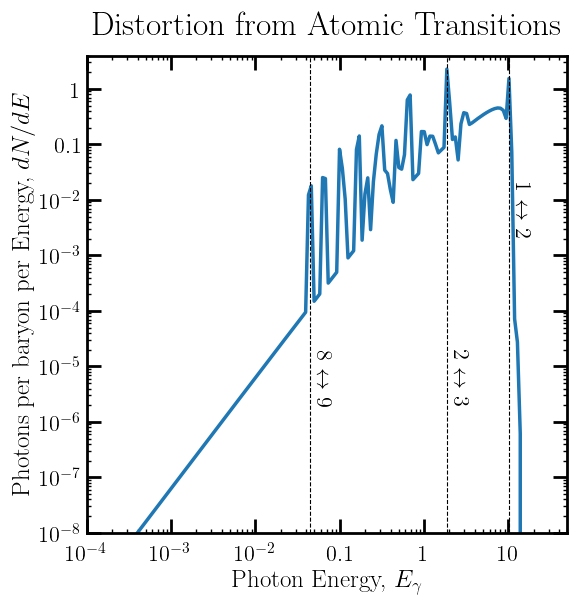

In [74]:
plt.figure()
plt.axis([1e-4,50, 1e-8, 4])
plt.loglog()
plt.plot(transition_spec.eng, transition_spec.N*1e16)

plt.axvline(E(2)-E(3), linewidth=0.8, color='k', linestyle='--')
plt.text((E(2)-E(3))*1.02, 1e-5, r'2 $\leftrightarrow$ 3', fontsize=16.0, rotation=270)

plt.axvline(E(8)-E(9), linewidth=0.8, color='k', linestyle='--')
plt.text((E(8)-E(9))*1.02, 1e-5, r'8 $\leftrightarrow$ 9', fontsize=16.0, rotation=270)


plt.axvline(E(1)-E(2), linewidth=0.8, color='k', linestyle='--')
plt.text((E(1)-E(2))*1.02, 1e-2, r'1 $\leftrightarrow$ 2', fontsize=16.0, rotation=270)

# plt.axvline(E(2)-E(3), linewidth=1.0, color='k', linestyle='--', label='n=2 to 3')

plt.xlabel(r'Photon Energy, $E_{\gamma}$')
plt.ylabel(r'Photons per baryon per Energy, $dN/dE$')
plt.title('Distortion from Atomic Transitions')

Text(0.5, 1.0, 'Testing the TLA Assumptions')

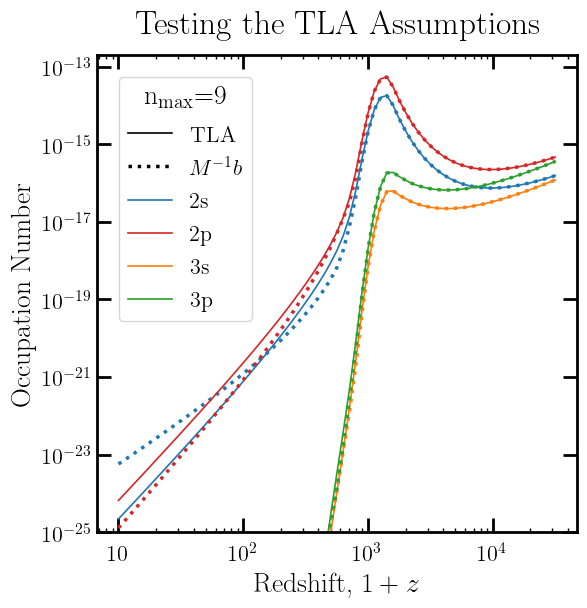

In [102]:
plt.figure()
plt.loglog()
plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

# plt.plot(rs_vec, xe_vec*1e-13, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)
# plt.plot(rs_vec, Tm_vec*1e-14, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)

lw=1.2

plt.plot(rs_vec, np.ones_like(rs_vec), label=r'TLA', color='k', linewidth=lw)
plt.plot(rs_vec, np.ones_like(rs_vec), label=r'$M^{-1} b$', color='k', linestyle=':')

plt.plot(rs_vec, x2s_vec, label='2s', color='C0', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,0], color='C0', linestyle=':')

plt.plot(rs_vec, 3*x2s_vec, label='2p', color='C3', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,1], color='C3', linestyle=':')

plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C1', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,2], color='C1', linestyle=':')

plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C2', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,3], color='C2', linestyle=':')

# plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C4', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,4], color='C4', linestyle=':')

# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Testing the TLA Assumptions')

Text(0.5, 1.0, 'Testing the TLA Assumptions')

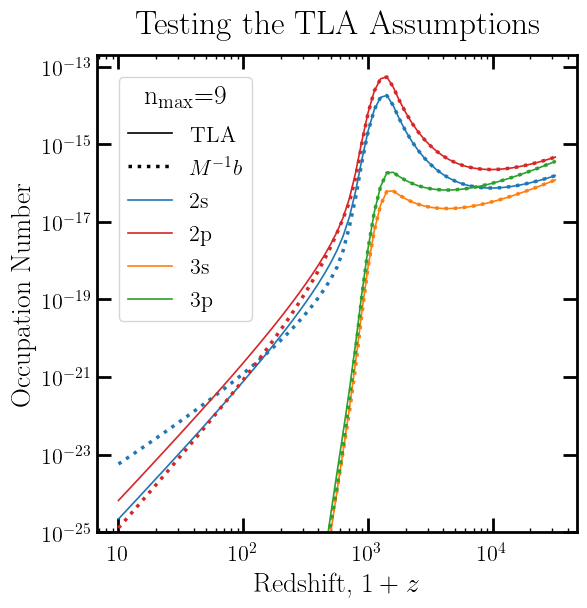

In [21]:
plt.figure()
plt.loglog()
plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

# plt.plot(rs_vec, xe_vec*1e-13, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)
# plt.plot(rs_vec, Tm_vec*1e-14, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)

lw=1.2

plt.plot(rs_vec, np.ones_like(rs_vec), label=r'TLA', color='k', linewidth=lw)
plt.plot(rs_vec, np.ones_like(rs_vec), label=r'$M^{-1} b$', color='k', linestyle=':')

plt.plot(rs_vec, x2s_vec, label='2s', color='C0', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,0], color='C0', linestyle=':')

plt.plot(rs_vec, 3*x2s_vec, label='2p', color='C3', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,1], color='C3', linestyle=':')

plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C1', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,2], color='C1', linestyle=':')

plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C2', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,3], color='C2', linestyle=':')

# plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C4', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,4], color='C4', linestyle=':')

# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Testing the TLA Assumptions')

Text(0.5, 1.0, 'Testing the TLA Assumptions')

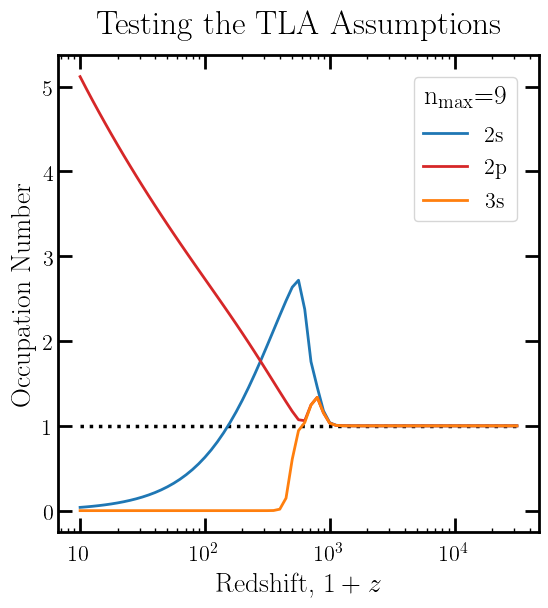

In [22]:
plt.figure()
# plt.loglog()
plt.xscale('log')
# plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

# plt.plot(rs_vec, xe_vec*1e-13, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)
# plt.plot(rs_vec, Tm_vec*1e-14, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)

lw=2.0

# plt.plot(rs_vec, np.ones_like(rs_vec), label=r'TLA', color='k', linewidth=lw)
plt.plot(rs_vec, np.ones_like(rs_vec), color='k', linestyle=':')

plt.plot(rs_vec, x2s_vec/x_vec[:,0], label='2s', color='C0', linewidth=lw)
plt.plot(rs_vec, 3*x2s_vec/x_vec[:,1], label='2p', color='C3', linewidth=lw)
plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec)/x_vec[:,2], 
         label='3s', color='C1', linewidth=lw)


# plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C1', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,2], color='C1', linestyle=':')

# plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C2', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,3], color='C2', linestyle=':')

# plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C4', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,4], color='C4', linestyle=':')

# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Testing the TLA Assumptions')

# Linear Algebra for Distortion

# Distortion

In [949]:
%autoreload
mDM = 3e10
# sigmav = xsec_bound_elec_CMB(mDM,'swave')
tau=1e25
species = 'elec'
DM_process = 'decay'
string = str(int(np.floor(np.log10(mDM))))
test_main = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=tau,
    primary=species+'_delta',
    start_rs = 3e3,
    coarsen_factor=12, backreaction=False, distort=False,
#     struct_boost=struct_boost,
    end_rs=2.5e3
)

In [950]:
spec10  = test_main['highengphot'][-1]
spec10.redshift(1)

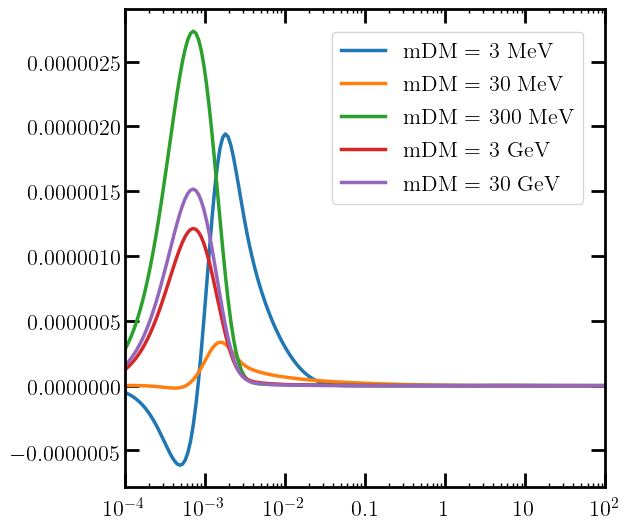

In [951]:
plt.figure()
plt.xscale('log')
plt.xlim([1e-4,100])
plt.plot(spec6.eng, spec6.eng*spec6.dNdE, label='mDM = 3 MeV')
plt.plot(spec.eng, spec.eng*spec.dNdE, label='mDM = 30 MeV')
plt.plot(spec8.eng, spec8.eng*spec8.dNdE, label='mDM = 300 MeV')
plt.plot(spec9.eng, spec9.eng*spec9.dNdE, label='mDM = 3 GeV')
plt.plot(spec10.eng, spec10.eng*spec10.dNdE, label='mDM = 30 GeV')
plt.legend()